# Sentiment Analysis - FineTuning Transformer Models

In [ ]:
!pip install transformers datasets evaluate huggingface_hub --quiet
!pip install accelerate -U --quiet
!pip install numpy pandas torch --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 4.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [ ]:
# Load our datasets

import pandas as pd

URL1 = "https://raw.githubusercontent.com/abdulmunimjemal/News-Sentiment-Analysis-Mobile-App/refs/heads/master/dataset/AMT_Clean.csv"
URL2 = "https://raw.githubusercontent.com/abdulmunimjemal/News-Sentiment-Analysis-Mobile-App/refs/heads/master/dataset/R_Clean.csv"

df1 = pd.read_csv(URL1)
df2 = pd.read_csv(URL2)

In [ ]:
print(df2.head())
df1.head()

   Unnamed: 0                                           headline entity  \
0           0  Boris Johnson Joins Trump in Redefining Conser...  Trump   
1           1       Trump Praises Controversial Hungarian Leader  Trump   
2           2  Stung by Trump’s Criticisms of Russian Gas Dea...  Trump   
3           3  What ‘America First’ Means Under Trump Is Comi...  Trump   
4           4  Trump Set to Meet With Russia’s Top Diplomat T...  Trump   

  majority_label  
0          neutr  
1            neg  
2          neutr  
3          neutr  
4          neutr  


,Unnamed: 0,headline,entity,majority_label
0,0,Russia and Poland Feud Over Putin Remarks on W...,Putin,Negative
1,1,Trump Moves to Lift Visa Restrictions on Polis...,Trump,Neutral
2,2,Trump-Backed U.S.-British Trade Deal Faces Hur...,Trump,Neutral
3,3,Trump’s Arrival in London Brings Controversy b...,Trump,Negative
4,4,Trump Steers Clear of War Footing Toward Iran,Trump,Neutral


In [ ]:
# let's assign the majority_label's values an integer
# 0 - Negative, 1 - Neutral, 2 - Positive
df1['label'] = df1['majority_label'].map({'Negative': 0, 'Neutral': 1, 'Positive': 2})
df2['label'] = df2['majority_label'].map({'neg': 0, 'neutr': 1, 'pos': 2})

# Let's merge the two datasets on headline and label only (ensure label is integer as well)
data = pd.concat([df1[['headline', 'label']], df2[['headline', 'label']]], axis=0)
data = data.drop_duplicates()
data = data.dropna()

# label must be itneger
data['label'] = data['label'].astype(int)

data.head()

,headline,label
0,Russia and Poland Feud Over Putin Remarks on W...,0
1,Trump Moves to Lift Visa Restrictions on Polis...,1
2,Trump-Backed U.S.-British Trade Deal Faces Hur...,1
3,Trump’s Arrival in London Brings Controversy b...,0
4,Trump Steers Clear of War Footing Toward Iran,1


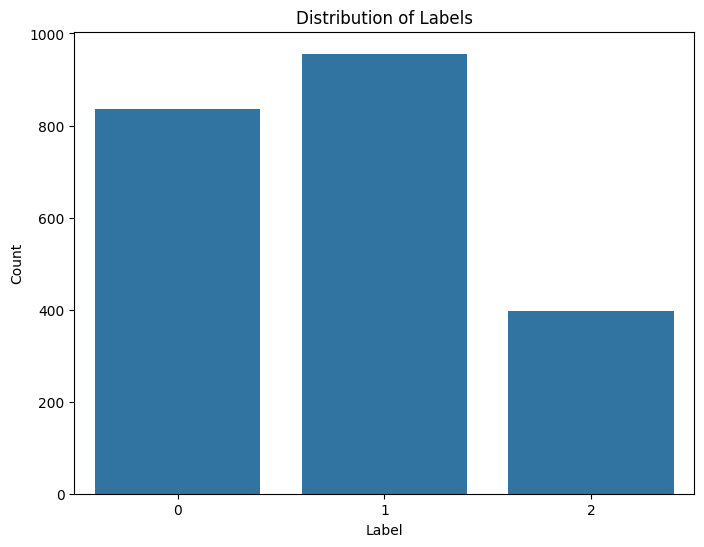

In [ ]:
# Simple Label and Count distribution visualization

def label_count_distribution(data):
  import matplotlib.pyplot as plt
  import seaborn as sns

  # Count the occurrences of each label
  label_counts = data['label'].value_counts()

  # Create a bar plot
  plt.figure(figsize=(8, 6))
  sns.barplot(x=label_counts.index, y=label_counts.values)
  plt.xlabel('Label')
  plt.ylabel('Count')
  plt.title('Distribution of Labels')
  plt.show()

label_count_distribution(data)


In [ ]:
# Let's increase the number of positive (2) labels by using sythentic data to create a balance

# Technique 1: Backtranslation

positive_data = data[data['label'] == 2]
positive_data.head()

,headline,label
8,"How Bernie Sanders Stumbled, Then Steadied His...",2
11,Trump Administration Awards Migrant Detention ...,2
25,Sen. Lindsey Graham says President Trump can r...,2
32,"Trump, Klobuchar see strong showing in New Ham...",2
33,Voters react to President Trump's New Hampshir...,2


In [ ]:
! pip install googletrans==4.0.0-rc1 --quiet

import pandas as pd
from googletrans import Translator

# Initialize the translator
translator = Translator()

# Create a list to store the synthetic data
synthetic_data = []

# Iterate through the positive data
for index, row in positive_data.iterrows():
    headline = row['headline']
    try:
        translated_headline = translator.translate(headline, dest='fr').text
        backtranslated_headline = translator.translate(translated_headline, dest='en').text
        synthetic_data.append({'headline': backtranslated_headline, 'label': row['label']})
    except Exception as e:
        print(f"Error translating headline: {headline}, Error: {e}")

synthetic_df = pd.DataFrame(synthetic_data)

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.1/55.1 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.0/65.0 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 46.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 3.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
langsmith 0.2.3 requires httpx<1,>=0.23.0, but you have httpx 0.13.3 which is incompatible.
openai 1.57.4 requires httpx<1,>=0.23.0, but you have httpx 0.13.3 which is incompatible.


In [ ]:
# Concatenate the original and synthetic DataFrames
data = pd.concat([data, synthetic_df], ignore_index=True)
data.drop_duplicates(inplace=True)

print(synthetic_df.head())
print(data.tail())

                                            headline  label
0  How Bernie Sanders tripped, then stabilized hi...      2
1  The Trump administration awards migrant detent...      2
2  Senator Lindsey Graham says that President Tru...      2
3  Trump, Klobuchar see a strong performance in t...      2
4  Voters react to President Trump's New Hampshir...      2
                                               headline  label
2579  Trump tears democrats on the eve of a probable...      2
2580  In the midst of adversity and false steps, the...      2
2581  "I really love you": the voters of the iowa gi...      2
2582  Trump's greatest supporters agree with a key a...      2
2583  Mike Bloomberg, 77, in "exceptional health", s...      2


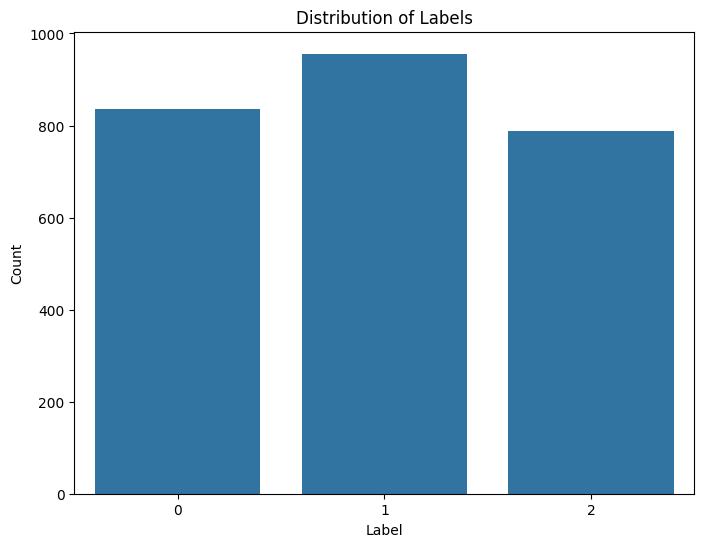

In [ ]:
label_count_distribution(data)

In [ ]:
# Let's save our new balanced data to a file
data.to_csv('balanced_news_synthetic_data.csv', index=False)

In [ ]:
# Session crash: We will load from the saved file and continue
data = pd.read_csv('balanced_news_synthetic_data.csv')
data.head()

In [ ]:
# Let's do some cleaning

import string
import nltk

nltk.download('punkt_tab')
nltk.download('stopwords')

def preprocess(text):
    # Remove Punctuations
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Lower case
    text = text.lower()
    # Remove Stopwords
    stop_words = set(nltk.corpus.stopwords.words('english'))
    tokens = nltk.word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    text = ' '.join(tokens)
    return text

data['headline'] = data['headline'].apply(preprocess)

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
data.head()

,headline,label
0,russia poland feud putin remarks world war ii,0
1,trump moves lift visa restrictions polish citi...,1
2,trumpbacked usbritish trade deal faces hurdles,1
3,trump ’ arrival london brings controversy litt...,0
4,trump steers clear war footing toward iran,1


In [ ]:
from sklearn.model_selection import train_test_split
from datasets import Dataset
import numpy as np

X = data['headline'] # Feature
y = data['label'] # Label


# Split our data to train and test dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Create training and test dataframe

train_df = pd.DataFrame({'text': X_train, 'label': y_train})
test_df = pd.DataFrame({'text': X_test, 'label': y_test})


print(f"Training set shape: {train_df.shape}")
print(f"Validation set shape: {test_df.shape}")

Training set shape: (2064, 2)
Validation set shape: (516, 2)


In [ ]:
# Convert our pandas dataframe to transformers dataframe

train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

In [ ]:
# Now, let's fientune BERT

from huggingface_hub import notebook_login

notebook_login()

Make sure to get your token from huggingface to login

In [ ]:
from sklearn.metrics import accuracy_score, f1_score
import torch
from transformers import AutoModelForSequenceClassification, AutoTokenizer, TrainingArguments, Trainer

# Load the pre-trained BERT model and tokenizer
bert_model = AutoModelForSequenceClassification.from_pretrained("nlptown/bert-base-multilingual-uncased-sentiment", num_labels=3, ignore_mismatched_sizes=True)
bert_tokenizer = AutoTokenizer.from_pretrained("nlptown/bert-base-multilingual-uncased-sentiment")

# Tokenize our feature data with tokenizer from BERT
def preprocess_function(examples, tokenizer):
    return tokenizer(examples["text"], truncation=True, padding="max_length", max_length=512)

bert_train = train_dataset.map(lambda x: preprocess_function(x, bert_tokenizer), batched=True)
bert_test = test_dataset.map(lambda x: preprocess_function(x, bert_tokenizer), batched=True)

# Define metrics that you want model to show it on evaluation process
def compute_metrics(eval_pred):
    logits, labels = eval_pred

    predictions = np.argmax(logits, axis=-1)
    return {
        'accuracy': accuracy_score(labels, predictions),
        'f1': f1_score(labels, predictions, average='weighted')
    }

config.json:   0%|          | 0.00/953 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/669M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at nlptown/bert-base-multilingual-uncased-sentiment and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([5]) in the checkpoint and torch.Size([3]) in the model instantiated
- classifier.weight: found shape torch.Size([5, 768]) in the checkpoint and torch.Size([3, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/39.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/872k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Map:   0%|          | 0/2064 [00:00<?, ? examples/s]

Map:   0%|          | 0/516 [00:00<?, ? examples/s]

In [ ]:
total_params = sum(p.numel() for p in bert_model.parameters())
print(f"Total parameters: {total_params}")

# Let's see the number of param we have with the BERT that will be trained.
trainable_params = sum(p.numel() for p in bert_model.parameters() if p.requires_grad)
print(f"Total trainable parameters: {trainable_params}")

Total parameters: 167358723
Total trainable parameters: 167358723


In [ ]:
def train_model(model, tokenizer, train_dataset, val_dataset, model_name):
    training_args = TrainingArguments(
        output_dir=f"./results_{model_name}",
        learning_rate=5e-5,
        per_device_train_batch_size=8,
        per_device_eval_batch_size=8,
        num_train_epochs=10,
        weight_decay=0.01,
        evaluation_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics
    )

    trainer.train()

    return trainer

In [ ]:
bert_trainer = train_model(bert_model, bert_tokenizer, bert_train, bert_test, "bert_full")

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-20-52440adfc9ed>:14: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,1.102520,0.439922,0.352075
2,1.076500,1.061969,0.453488,0.365685
3,1.076500,1.040749,0.549612,0.487567
4,0.978500,1.021130,0.609690,0.603778
5,0.978500,1.074635,0.711628,0.700621
6,0.061980,0.038398,0.815504,0.812187
7,0.041980,0.013824,0.894574,0.885693
8,0.022900,0.012841,0.911008,0.912660
9,0.009400,0.004193,0.935194,0.948752
10,0.007100,0.005724,0.952070,0.953305


In [ ]:
bert_trainer.push_to_hub("abdulmunimjemal/news_sentiment_analysis")
bert_tokenizer.push_to_hub("abdulmunimjemal/news_sentiment_analysis")

bert_trainer.save_model("./sentiment_analysis")
bert_tokenizer.save_pretrained("./sentiment_analysis")


model.safetensors:   0%|          | 0.00/669M [00:00<?, ?B/s]

Upload 3 LFS files:   0%|          | 0/3 [00:00<?, ?it/s]

training_args.bin:   0%|          | 0.00/5.37k [00:00<?, ?B/s]

events.out.tfevents.1736071197.c181a4722a96.1760.0:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

('./sentiment_analysis/tokenizer_config.json',
 './sentiment_analysis/special_tokens_map.json',
 './sentiment_analysis/vocab.txt',
 './sentiment_analysis/added_tokens.json',
 './sentiment_analysis/tokenizer.json')

In [ ]:
! pip install ai-edge-torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.9/210.9 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.7/100.7 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 633.9/633.9 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.6/90.6 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 33.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 44.2 MB/s eta 0:00:00


In [ ]:
! export PJRT_DEVICE=CPU

In [ ]:
import ai_edge_torch
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import torch

# Move model and input to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
dummy_input = dummy_input.to(device)

model = AutoModelForSequenceClassification.from_pretrained("./sentiment_analysis")
dummy_input = torch.randint(0, 100, (1, 512))

edge_model = ai_edge_torch.convert(model.eval(), (dummy_input,))
edge_model.export("sentiment_analysis.tflite")